# Импорт библиотек

In [3]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from typing import Tuple, Union, List
from tqdm import tqdm

IN_COLAB = False

# Настройка окружения

In [70]:
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 24
plt.rcParams["figure.figsize"] = (12, 7)

SEED = 42

if IN_COLAB:
    figures_dir = './'
else:
    figures_dir = '../figures/'

# Работа с данными

In [67]:
rootpath = '/home/eduard/git/HTNet/' # pulling results from rootpath+dataset directory
dataset = 'move_rest_ecog/combined_sbjs_power/'
full_path = rootpath + dataset

rnn_acc = np.load(full_path + 'acc_gen_rnn_36.npy')
s4_acc = np.load(full_path + 'acc_gen_s4_36.npy')
ncde_acc = np.load(full_path + 'acc_gen_ncde_36.npy')

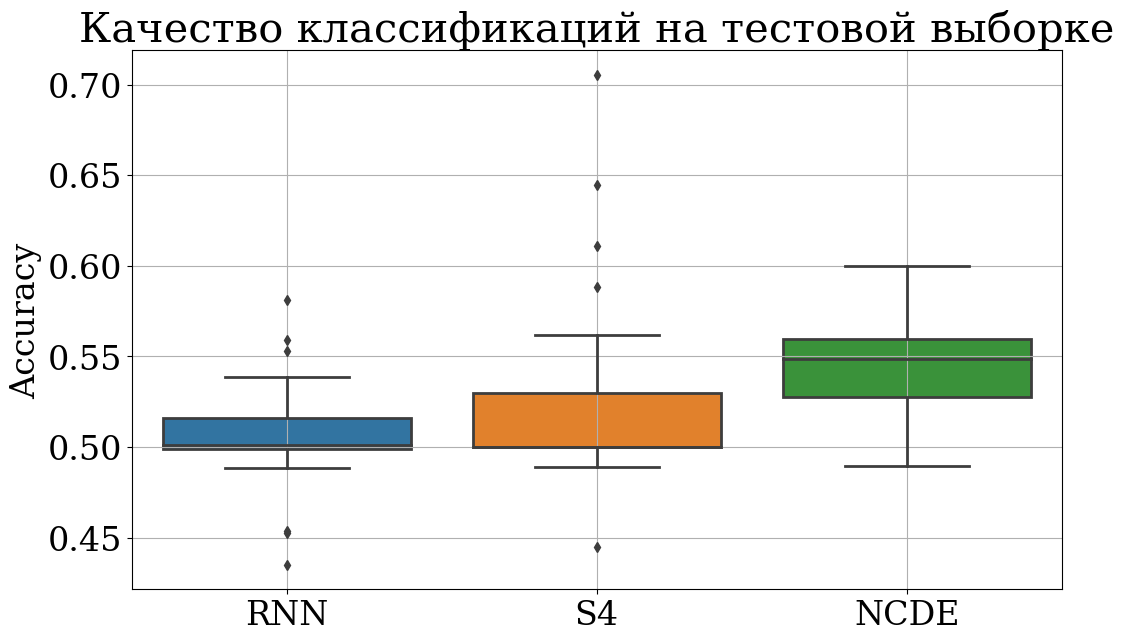

In [78]:
ax = plt.gca()
sns.boxplot([rnn_acc[:, -1], s4_acc[:, -1], ncde_acc[:, -1]], ax=ax)
plt.xticks(range(3), ['RNN', 'S4', 'NCDE'])
plt.ylabel('Accuracy')
plt.grid(True)
plt.title('Качество классификаций на тестовой выборке')
plt.savefig('rnn-s4-ncde.png')
plt.show()

In [74]:
rnn_acc[:, -1].mean(), rnn_acc[:, -1].std()

(0.5061688526846104, 0.027222627568199754)

In [75]:
s4_acc[:, -1].mean(), s4_acc[:, -1].std()

(0.5210854088633703, 0.048762742434324526)

In [76]:
ncde_acc[:, -1].mean(), ncde_acc[:, -1].std()

(0.5455534400103386, 0.026470510400540662)